# Notebook 05: Continuous Manifold & Dynamics

**Purpose**: Recover the underlying manifold structure and analyze dynamics (Probability Flux, Committors) directly on it, rather than forcing discrete clustering on potentially continuous data.


**Rationale**:
- **TICA**: Find slow collective variables before manifold learning (PyEMMA standard)
- **Diffusion Maps**: Recover intrinsic geometry (Riemannian metric) and the underlying differential operator (Fokker-Planck/Laplace-Beltrami) from data
- **HDBSCAN**: Density-based clustering with stability scores (handles noise, data-driven cluster count)
- **TPT**: Define basins and reaction channels rigorously using Committor functions ($q_+$) and Probability Current ($f^R_{ij}$)

## 1. Setup & Configuration

In [1]:
# ============================================================================
# COLAB SETUP - Run this cell first!
# ============================================================================
import sys
from pathlib import Path

# Detect if running in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab")

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Set up paths
    DRIVE_ROOT = Path('/content/drive/MyDrive/chaos')
    DRIVE_ROOT.mkdir(parents=True, exist_ok=True)

    print(f"Drive mounted. Project root: {DRIVE_ROOT}")

    # Install dependencies
    print("Installing dependencies...")
    !pip install -q torch>=2.0.0 h5py>=3.8.0 sgfmill>=1.1.0
    !pip install -q matplotlib>=3.7.0 tqdm>=4.65.0
    !pip install -q scikit-learn>=1.2.0 scipy>=1.10.0
    !pip install -q pydiffmap deeptime  # Key libraries for this notebook
    !pip install -q psutil joblib
    print("Dependencies installed!")

    # Unzip src.zip
    !unzip -n -q src.zip -d /content/
else:
    print("Running locally")
    DRIVE_ROOT = None

Running in Google Colab
Mounted at /content/drive
Drive mounted. Project root: /content/drive/MyDrive/chaos
Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.1 MB/s eta 0:00:00
Dependencies installed!


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import time
from contextlib import contextmanager
from typing import Optional, Tuple, Dict, List

# ============================================================================
# TIMING INFRASTRUCTURE
# ============================================================================
@contextmanager
def timed_section(name):
    """Context manager to time code sections."""
    start = time.time()
    print(f"[START] {name}...")
    yield
    elapsed = time.time() - start
    print(f"[DONE] {name}: {elapsed:.1f}s ({elapsed/60:.1f} min)")

# Add src to path
if IN_COLAB:
    sys.path.insert(0, '/content')
sys.path.insert(0, str(Path('.').absolute()))

# Import analysis modules
from src.analysis.diffusion_maps import (
    DiffusionMapAnalyzer,
    compute_diffusion_map,
    compute_diffusion_map_scipy,
)
from src.analysis.tpt import (
    TPTAnalyzer,
    compute_tpt,
    save_tpt_result,
)
from src.analysis.transition_matrix import (
    TransitionMatrixAnalyzer,
)
from src.analysis.tica import (
    TICATransformer,
    fit_tica_with_variance_cutoff,
    compute_implied_timescales_multi_lag,
)

print("Modules loaded successfully")

# ============================================================================
# CONFIGURATION (Updated per literature cross-reference)
# ============================================================================
CONFIG = {
    'block_idx': 35,  # Strategic layer (deep block for highest abstraction)

    # TICA settings (NEW - per CLAUDE.md requirement)
    'tica_lag': 1,
    'tica_n_components': 50,  # Will auto-select via 95% kinetic variance

    # Diffusion Map settings (Updated per recommendations)
    'dm_n_components': 50,    # Number of diffusion coordinates
    'dm_alpha': 1.0,          # α=1 for Laplace-Beltrami (density-independent)
    'dm_n_landmarks': 10000,  # Increased from 5000 for denser kernel

    # TPT settings (Updated per recommendations)
    'tpt_lag': 1,
    'tpt_pathway_fraction': 0.9,  # Capture 90% of reactive flux
    'early_game_threshold': 0.15,  # Reduced from 0.2 to reduce overlap
    'late_game_threshold': 0.85,   # Increased from 0.8 to reduce overlap

    # HDBSCAN settings (NEW - per CLAUDE.md: use HDBSCAN not K-means)
    'hdbscan_min_cluster_size': 50,
    'hdbscan_min_samples': 10,

    # MSM Validation settings (NEW)
    'its_lag_values': [1, 2, 3, 5, 10],  # For ITS convergence test
    'ck_k_values': [2, 3, 5],  # For Chapman-Kolmogorov test

    # Subsampling for efficiency
    'max_samples_diffmap': 50000,  # Max samples for diffusion map fitting

    # Paths - will be overridden for Colab
    'features_dir': 'outputs/data/sae_features',
    'metadata_dir': 'outputs/data/metadata',
    'pca_results_dir': 'outputs/analysis/pca_baseline',
    'output_dir': 'outputs/analysis/continuous_manifold',
}

# Colab path configuration
if IN_COLAB:
    CONFIG['features_dir'] = str(DRIVE_ROOT / 'data' / 'sae_features')
    CONFIG['metadata_dir'] = str(DRIVE_ROOT / 'data' / 'metadata')
    CONFIG['pca_results_dir'] = str(DRIVE_ROOT / 'analysis' / 'pca_baseline')
    CONFIG['output_dir'] = str(DRIVE_ROOT / 'analysis' / 'continuous_manifold')

    print(f"Features dir: {CONFIG['features_dir']}")
    print(f"Output dir: {CONFIG['output_dir']}")

# Create output directory
Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

## 2. Data Loading (The Foundation)

In [3]:
# ============================================================================
# LOAD SAE FEATURES
# ============================================================================
with timed_section("Loading SAE features"):
    features_path = Path(CONFIG['features_dir']) / f"block{CONFIG['block_idx']}_features.h5"

    if not features_path.exists():
        # Try .npy format
        features_path_npy = Path(CONFIG['features_dir']) / f"block{CONFIG['block_idx']}_features.npy"
        if features_path_npy.exists():
            features = np.load(features_path_npy)
            print(f"Loaded features from NPY: {features.shape}")
        else:
            raise FileNotFoundError(f"Features not found: {features_path} or {features_path_npy}")
    else:
        with h5py.File(features_path, 'r') as f:
            # Find dataset key
            dataset_key = 'features' if 'features' in f else list(f.keys())[0]
            features = f[dataset_key][()].astype(np.float32)
        print(f"Loaded features from HDF5: {features.shape}")

    n_samples, n_features = features.shape
    print(f"\nTotal samples: {n_samples:,}")
    print(f"Feature dimension: {n_features}")

[START] Loading SAE features...
Loaded features from HDF5: (495995, 4096)

Total samples: 495,995
Feature dimension: 4096
[DONE] Loading SAE features: 31.8s (0.5 min)


In [4]:
# ============================================================================
# LOAD GAME METADATA
# ============================================================================
# Load metadata (game_ids for trajectory analysis)
metadata = None

# PRIMARY: Load from positions.hdf5 (where NB01 stores it)
positions_h5_path = Path(CONFIG['features_dir']).parent / 'positions.hdf5'
if not positions_h5_path.exists():
    # Try Colab path structure
    positions_h5_path = Path(CONFIG['features_dir']).parent.parent / 'data' / 'positions.hdf5'

with timed_section("Loading game metadata"):
    if positions_h5_path.exists():
        print(f"Loading metadata from positions.hdf5...")
        with h5py.File(positions_h5_path, 'r') as f:
            print(f"  Available keys: {list(f.keys())}")

            if 'game_ids' in f and 'move_numbers' in f:
                game_ids = f['game_ids'][()]
                move_numbers = f['move_numbers'][()]
                print(f"Loaded metadata: {len(game_ids)} positions")

                # Compute game phase if we have total_moves
                if 'total_moves' in f:
                    total_moves = f['total_moves'][()]
                    game_phase = move_numbers / np.maximum(total_moves, 1)
                else:
                    # Compute game phase from actual game lengths (not fixed 200)
                    # This ensures game_phase spans [0, 1] for each game
                    unique_games, inverse = np.unique(game_ids, return_inverse=True)
                    game_lengths = np.bincount(inverse)
                    total_moves_computed = game_lengths[inverse]
                    game_phase = move_numbers / np.maximum(total_moves_computed, 1)
                    print(f"  Computed game_phase from {len(unique_games)} games")
                    print(f"  Game lengths: min={game_lengths.min()}, max={game_lengths.max()}, median={np.median(game_lengths):.0f}")
                    print(f"  Game phase range: [{game_phase.min():.3f}, {game_phase.max():.3f}]")

                # Align with features if needed
                if len(game_ids) != n_samples:
                    print(f"WARNING: Metadata length ({len(game_ids)}) != feature length ({n_samples})")
                    min_len = min(len(game_ids), n_samples)
                    features = features[:min_len]
                    game_ids = game_ids[:min_len]
                    move_numbers = move_numbers[:min_len]
                    game_phase = game_phase[:min_len]
                    n_samples = min_len
            else:
                print(f"WARNING: Required keys not found in {positions_h5_path}")
                print(f"  Expected: game_ids, move_numbers")
                print(f"  Found: {list(f.keys())}")
                game_ids = np.arange(n_samples, dtype=np.int32)
                move_numbers = np.zeros(n_samples, dtype=np.int32)
                game_phase = np.zeros(n_samples, dtype=np.float32)
    else:
        print(f"WARNING: Metadata not found at {positions_h5_path}")
        game_ids = np.arange(n_samples, dtype=np.int32)
        move_numbers = np.zeros(n_samples, dtype=np.int32)
        game_phase = np.zeros(n_samples, dtype=np.float32)

[START] Loading game metadata...
Loading metadata from positions.hdf5...
  Available keys: ['game_ids', 'move_numbers', 'positions']
Loaded metadata: 495995 positions
  Computed game_phase from 4999 games
  Game lengths: min=67, max=100, median=100
  Game phase range: [0.100, 1.134]
[DONE] Loading game metadata: 2.0s (0.0 min)


## 3. TICA Preprocessing

TICA finds linear combinations of features that maximize autocorrelation, revealing the **slowest dynamical modes**. This is critical preprocessing before manifold learning because:

1. **Reduces dimensionality** while preserving dynamics
2. **Focuses on slow collective variables** that matter for strategy evolution
3. **Filters out fast noise** that confuses diffusion map geometry

In [ ]:
with timed_section("TICA preprocessing"):
    # Subsample for TICA fitting if needed
    subsample_size = min(CONFIG['max_samples_diffmap'], n_samples)
    if n_samples > subsample_size:
        subsample_idx = np.random.choice(n_samples, subsample_size, replace=False)
        subsample_idx.sort()
        features_sub = features[subsample_idx]
        game_ids_sub = game_ids[subsample_idx]
        game_phase_sub = game_phase[subsample_idx]
        print(f"Subsampled: {n_samples:,} → {subsample_size:,} samples")
    else:
        features_sub = features
        game_ids_sub = game_ids
        game_phase_sub = game_phase
        subsample_idx = np.arange(n_samples)

    # Fit TICA with 95% kinetic variance cutoff (per PyEMMA paper)
    tica, n_tica_selected = fit_tica_with_variance_cutoff(
        features_sub,
        game_ids=game_ids_sub,
        lag=CONFIG['tica_lag'],
        variance_threshold=0.95,
        max_components=CONFIG['tica_n_components'],
    )

    # Transform to TICA space
    features_tica = tica.transform(features_sub)

    print(f"\nTICA Results:")
    print(f"  Input dimension: {features_sub.shape[1]}")
    print(f"  Output dimension: {features_tica.shape[1]}")
    print(f"  Components for 95% kinetic variance: {n_tica_selected}")
    print(f"  Top 5 TICA eigenvalues: {tica.result_.eigenvalues[:5]}")

    # Compute implied timescales for TICA modes
    tica_timescales = tica.get_implied_timescales(lag_time=CONFIG['tica_lag'])
    print(f"  Top 5 implied timescales: {tica_timescales[:5]}")

In [ ]:
# ============================================================================
# PCA BASELINE (for comparison with TICA + Diffusion Maps)
# ============================================================================
from sklearn.decomposition import PCA, IncrementalPCA

with timed_section("Computing PCA baseline on TICA features"):
    # Use TICA-transformed features (already subsampled)
    n_pca_components = min(100, features_tica.shape[1], features_tica.shape[0])
    pca = PCA(n_components=n_pca_components)
    pca_coords = pca.fit_transform(features_tica)
    pca_eigenvalues = pca.explained_variance_
    pca_explained_ratio = pca.explained_variance_ratio_
    pca_cumvar = np.cumsum(pca_explained_ratio)

    print(f"\nPCA Results (on TICA features):")
    print(f"  Components: {n_pca_components}")
    print(f"  Variance explained (first 10): {pca_explained_ratio[:10]}")
    print(f"  Cumulative variance (10 components): {pca_cumvar[min(9, len(pca_cumvar)-1)]:.2%}")
    print(f"  Cumulative variance (50 components): {pca_cumvar[min(49, len(pca_cumvar)-1)]:.2%}")

In [ ]:
# ============================================================================
# DIFFUSION MAP COMPUTATION (on TICA-transformed features)
# ============================================================================
with timed_section("Computing Diffusion Map on TICA features"):
    print("="*60)
    print("DIFFUSION MAP ANALYSIS (on TICA-preprocessed features)")
    print(f"α={CONFIG['dm_alpha']} (Laplace-Beltrami, density-independent)")
    print(f"Landmarks: {CONFIG['dm_n_landmarks']} (Nyström approximation)")
    print("="*60)

    # Initialize analyzer with updated parameters
    dm_analyzer = DiffusionMapAnalyzer(
        n_components=CONFIG['dm_n_components'],
        alpha=CONFIG['dm_alpha'],
        n_landmarks=CONFIG['dm_n_landmarks'],  # Increased to 10000
        random_state=42
    )

    # Fit and transform on TICA features (not raw features)
    dm_coords, dm_eigenvalues = dm_analyzer.fit_transform(features_tica)

    print(f"\nDiffusion Map Results:")
    print(f"  Input: {features_tica.shape[1]} TICA dimensions")
    print(f"  Output shape: {dm_coords.shape}")
    print(f"  Eigenvalues (first 10): {dm_eigenvalues[:10]}")

    # Compute implied timescales
    dm_timescales = dm_analyzer.compute_implied_timescales(t=1)
    print(f"  Implied timescales (first 10): {dm_timescales[:10]}")

    # Compute spectral gap (key diagnostic)
    if len(dm_eigenvalues) > 1:
        spectral_gap = dm_eigenvalues[0] / dm_eigenvalues[1]
        print(f"\n  Spectral gap (λ₁/λ₂): {spectral_gap:.4f}")
        if spectral_gap > 1.1:
            print("  ✓ Good spectral gap - meaningful structure detected")
        else:
            print("  ⚠ No clear spectral gap - data may have disconnected components")

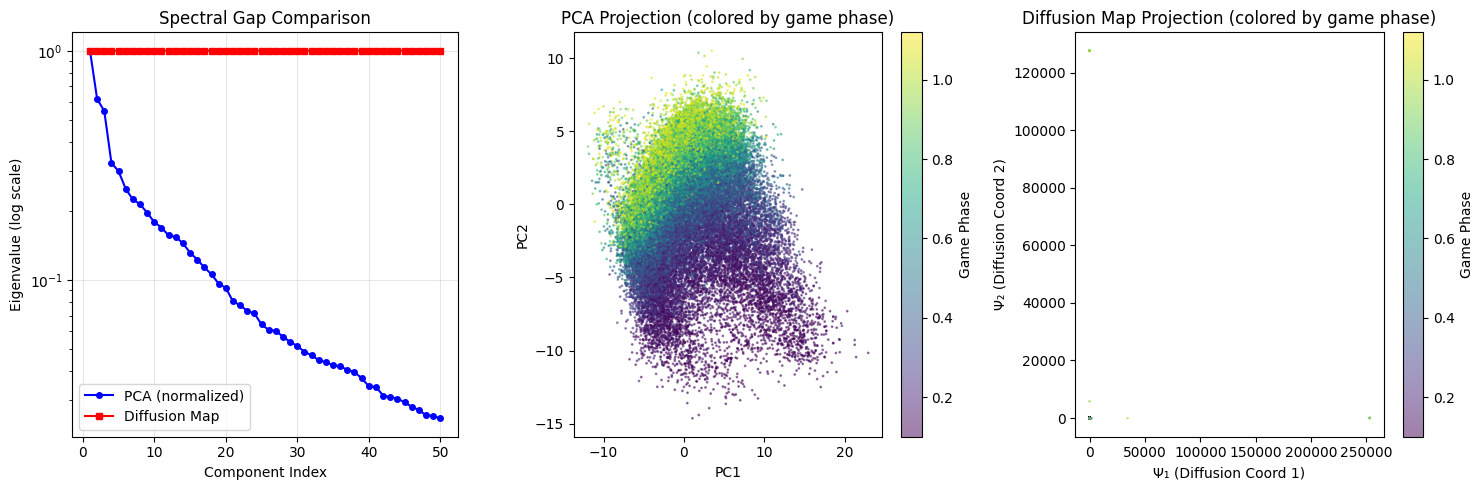


INTERPRETATION:
- If Diffusion Map shows smoother 'unfolded' trajectories vs PCA,
  the manifold hypothesis is supported.
- If both look similar, linear methods may suffice.


In [7]:
# ============================================================================
# COMPARE SPECTRAL GAPS: PCA vs Diffusion Maps
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Panel 1: Eigenvalue decay comparison
ax1 = axes[0]
n_compare = min(50, len(pca_eigenvalues), len(dm_eigenvalues))
ax1.semilogy(range(1, n_compare+1), pca_eigenvalues[:n_compare] / pca_eigenvalues[0],
             'b-o', label='PCA (normalized)', markersize=4)
ax1.semilogy(range(1, n_compare+1), dm_eigenvalues[:n_compare],
             'r-s', label='Diffusion Map', markersize=4)
ax1.set_xlabel('Component Index')
ax1.set_ylabel('Eigenvalue (log scale)')
ax1.set_title('Spectral Gap Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: 2D PCA projection
ax2 = axes[1]
scatter2 = ax2.scatter(pca_coords[:, 0], pca_coords[:, 1],
                       c=game_phase_sub, cmap='viridis', s=1, alpha=0.5)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('PCA Projection (colored by game phase)')
plt.colorbar(scatter2, ax=ax2, label='Game Phase')

# Panel 3: 2D Diffusion Map projection
ax3 = axes[2]
scatter3 = ax3.scatter(dm_coords[:, 0], dm_coords[:, 1],
                       c=game_phase_sub, cmap='viridis', s=1, alpha=0.5)
ax3.set_xlabel('Ψ₁ (Diffusion Coord 1)')
ax3.set_ylabel('Ψ₂ (Diffusion Coord 2)')
ax3.set_title('Diffusion Map Projection (colored by game phase)')
plt.colorbar(scatter3, ax=ax3, label='Game Phase')

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'pca_vs_diffusion_map.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("INTERPRETATION:")
print("- If Diffusion Map shows smoother 'unfolded' trajectories vs PCA,")
print("  the manifold hypothesis is supported.")
print("- If both look similar, linear methods may suffice.")
print("="*60)

## 4. Manifold Reconstruction

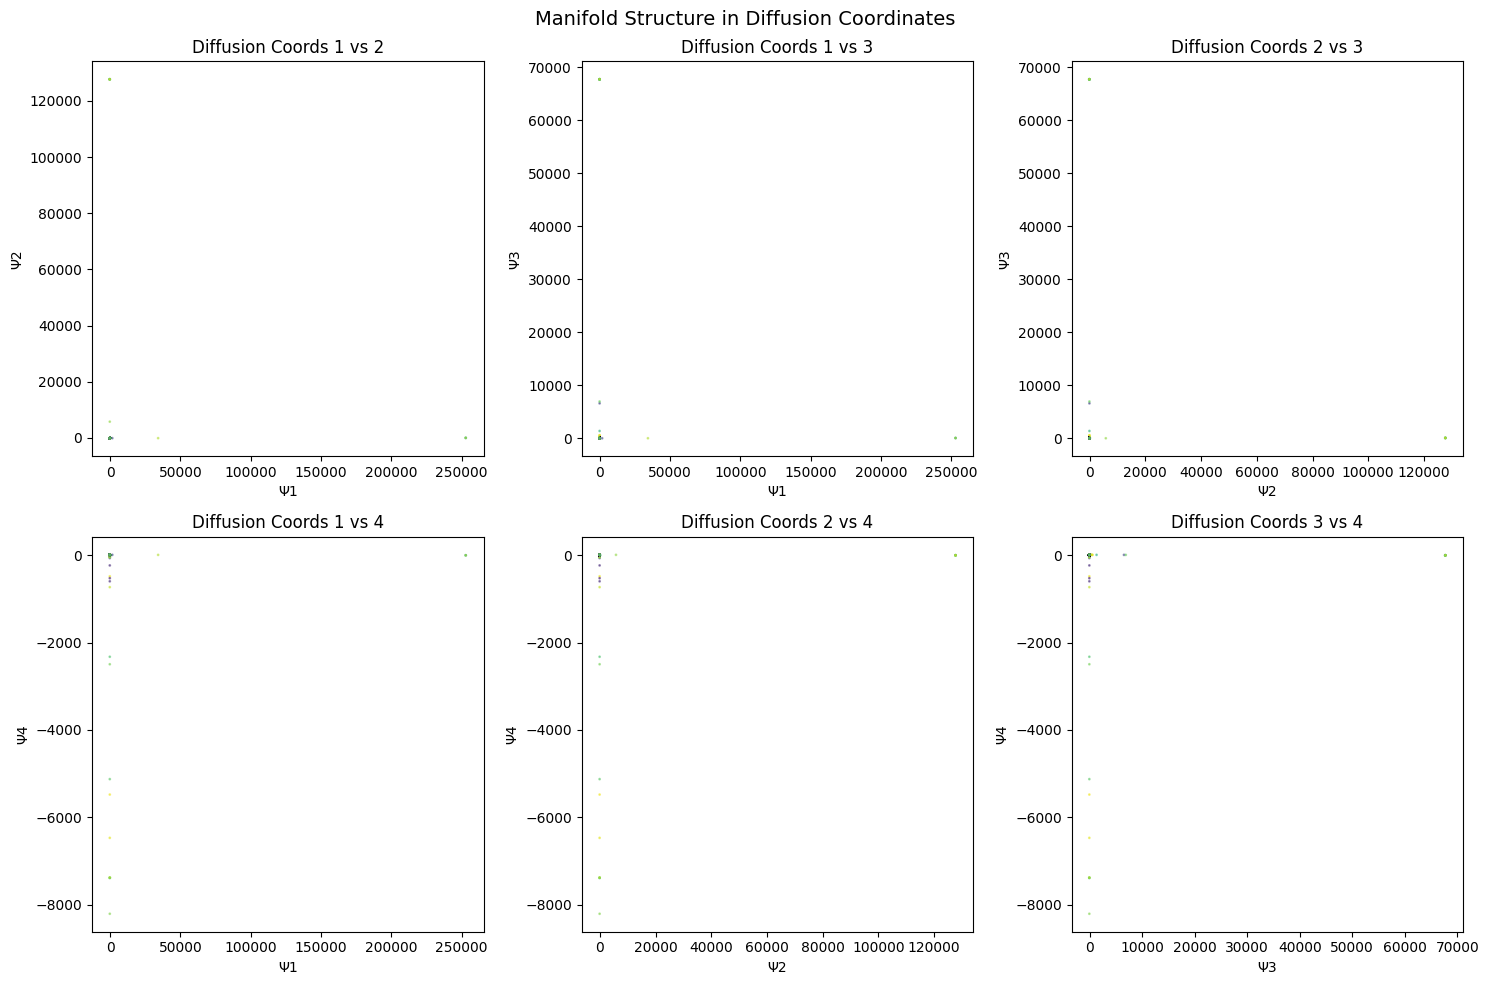

In [8]:
# ============================================================================
# VISUALIZE MANIFOLD STRUCTURE
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Different diffusion coordinate pairs
coord_pairs = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]

for ax, (i, j) in zip(axes.flat, coord_pairs):
    if i < dm_coords.shape[1] and j < dm_coords.shape[1]:
        scatter = ax.scatter(dm_coords[:, i], dm_coords[:, j],
                            c=game_phase_sub, cmap='viridis', s=1, alpha=0.5)
        ax.set_xlabel(f'Ψ{i+1}')
        ax.set_ylabel(f'Ψ{j+1}')
        ax.set_title(f'Diffusion Coords {i+1} vs {j+1}')
    else:
        ax.set_visible(False)

plt.suptitle('Manifold Structure in Diffusion Coordinates', fontsize=14)
plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'manifold_structure.png', dpi=150, bbox_inches='tight')
plt.show()

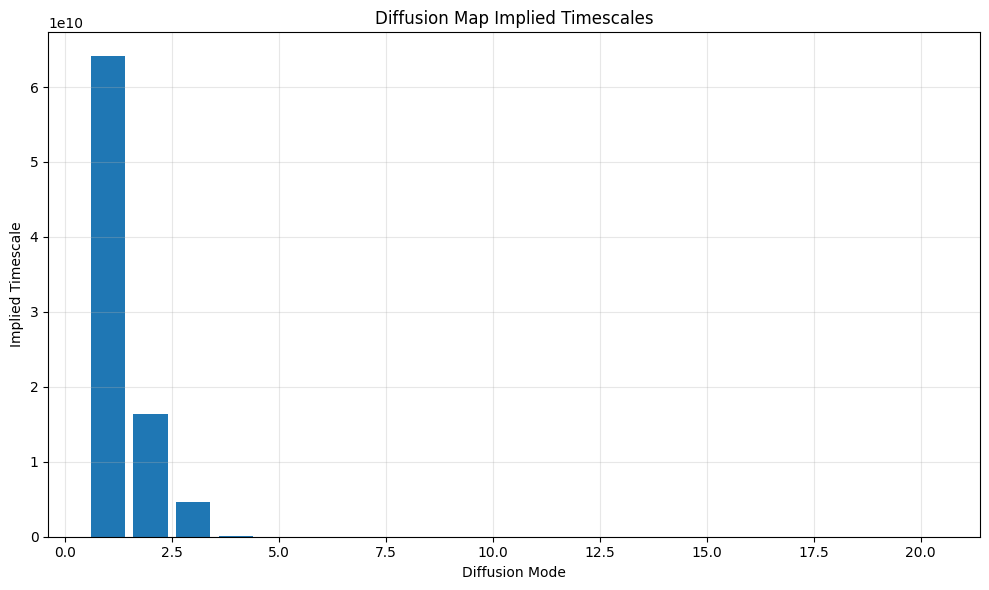

Top 5 timescales: [6.40940380e+10 1.63409244e+10 4.59465887e+09 1.22459189e+08
 2.13062398e+07]
Spectral gap (λ₁/λ₂): 1.000000000045594


In [9]:
# ============================================================================
# DIFFUSION TIMESCALES ANALYSIS
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

n_show = min(20, len(dm_timescales))
valid_timescales = dm_timescales[:n_show]
valid_timescales = valid_timescales[np.isfinite(valid_timescales)]

ax.bar(range(1, len(valid_timescales)+1), valid_timescales)
ax.set_xlabel('Diffusion Mode')
ax.set_ylabel('Implied Timescale')
ax.set_title('Diffusion Map Implied Timescales')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'diffusion_timescales.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Top 5 timescales: {valid_timescales[:5]}")
print(f"Spectral gap (λ₁/λ₂): {dm_eigenvalues[0]/dm_eigenvalues[1] if len(dm_eigenvalues) > 1 else 'N/A'}")

## 5. Attractor Identification

We identify "ends" of the manifold (attractors) using the diffusion coordinates. Early-game and end-game regions naturally separate in manifold space.

In [ ]:
# ============================================================================
# DEFINE SOURCE AND TARGET REGIONS (Updated thresholds per recommendations)
# ============================================================================
# Use game phase to define Source (early-game) and Target (end-game)
# Thresholds adjusted to reduce source/target overlap (0.2→0.15, 0.8→0.85)
early_game_threshold = CONFIG['early_game_threshold']  # 0.15 (was 0.2)
late_game_threshold = CONFIG['late_game_threshold']    # 0.85 (was 0.8)

source_mask = game_phase_sub < early_game_threshold
target_mask = game_phase_sub > late_game_threshold

print(f"Source/Target Definition (adjusted thresholds to reduce overlap):")
print(f"  Early game threshold: {early_game_threshold} (was 0.2)")
print(f"  Late game threshold: {late_game_threshold} (was 0.8)")
print(f"  Source (early-game) samples: {source_mask.sum():,} ({source_mask.mean():.1%})")
print(f"  Target (end-game) samples: {target_mask.sum():,} ({target_mask.mean():.1%})")

# Validate non-empty sets (required for TPT)
if source_mask.sum() == 0:
    print(f"WARNING: No source samples! game_phase range: [{game_phase_sub.min():.3f}, {game_phase_sub.max():.3f}]")
    print("Consider lowering early_game_threshold")
if target_mask.sum() == 0:
    print(f"WARNING: No target samples! game_phase range: [{game_phase_sub.min():.3f}, {game_phase_sub.max():.3f}]")
    print("Consider raising late_game_threshold or check game_phase computation")

# Visualize source/target regions
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all points
ax.scatter(dm_coords[:, 0], dm_coords[:, 1], c='lightgray', s=1, alpha=0.3, label='Intermediate')

# Highlight source and target
ax.scatter(dm_coords[source_mask, 0], dm_coords[source_mask, 1],
           c='blue', s=5, alpha=0.5, label=f'Source (phase < {early_game_threshold})')
ax.scatter(dm_coords[target_mask, 0], dm_coords[target_mask, 1],
           c='red', s=5, alpha=0.5, label=f'Target (phase > {late_game_threshold})')

ax.set_xlabel('Ψ₁')
ax.set_ylabel('Ψ₂')
ax.set_title('Source (Early-Game) and Target (End-Game) Regions\n(Adjusted thresholds: 0.15/0.85)')
ax.legend()

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'source_target_regions.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Continuous Dynamics (TPT)

Now we analyze the dynamics using Transition Path Theory:
- Compute forward committor $q_+(x)$: probability of reaching target before source
- Compute reactive flux: the "highways" of morphogenesis
- Identify bottleneck states: $q_+ \approx 0.5$

In [ ]:
# ============================================================================
# BUILD TRANSITION MATRIX ON DIFFUSION COORDINATES
# ============================================================================
# Per CLAUDE.md: "HDBSCAN (not K-means) — Density-based, stability scores, handles noise"
import hdbscan

with timed_section("Building transition matrix for TPT (HDBSCAN)"):
    print("="*60)
    print("CLUSTERING FOR TPT (HDBSCAN per CLAUDE.md)")
    print("  Reference: docs/topological_data_analysis/INDEX.md L:694-715")
    print("="*60)

    # Use HDBSCAN instead of k-means for density-based clustering
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=CONFIG['hdbscan_min_cluster_size'],
        min_samples=CONFIG['hdbscan_min_samples'],
        metric='euclidean',
        cluster_selection_method='eom',  # Excess of Mass
    )

    # Cluster in diffusion space
    state_labels = clusterer.fit_predict(dm_coords)

    # HDBSCAN diagnostics
    n_clusters = len(set(state_labels)) - (1 if -1 in state_labels else 0)
    n_noise = (state_labels == -1).sum()
    noise_fraction = n_noise / len(state_labels)

    print(f"\nHDBSCAN Results:")
    print(f"  Clusters found: {n_clusters} (data-driven, not fixed)")
    print(f"  Noise points: {n_noise:,} ({noise_fraction:.1%})")

    # Get stability scores for cluster quality
    if hasattr(clusterer, 'cluster_persistence_'):
        print(f"  Cluster stability scores: {clusterer.cluster_persistence_[:10]}")

    # Build transition matrix (respecting game boundaries)
    msm_analyzer = TransitionMatrixAnalyzer(lag=CONFIG['tpt_lag'])

    msm_result = msm_analyzer.fit(state_labels, game_ids_sub)

    print(f"\nMSM for TPT:")
    print(f"  States: {msm_result.n_states}")
    print(f"  Transitions: {msm_result.n_transitions:,}")

    # Validate: count transitions involving noise
    non_noise_mask = state_labels >= 0
    print(f"  Non-noise samples: {non_noise_mask.sum():,} ({non_noise_mask.mean():.1%})")

In [12]:
# ============================================================================
# IDENTIFY SOURCE AND TARGET STATES
# ============================================================================
# Map source/target masks to state labels
source_states = np.unique(state_labels[source_mask])
target_states = np.unique(state_labels[target_mask])

# Remove overlap (states that are both source and target)
overlap = np.intersect1d(source_states, target_states)
if len(overlap) > 0:
    print(f"WARNING: {len(overlap)} states are both source and target")
    # Keep top N by count
    source_counts = {s: (state_labels[source_mask] == s).sum() for s in source_states}
    target_counts = {s: (state_labels[target_mask] == s).sum() for s in target_states}

    # Assign to whichever has more
    for s in overlap:
        if source_counts.get(s, 0) > target_counts.get(s, 0):
            target_states = target_states[target_states != s]
        else:
            source_states = source_states[source_states != s]

print(f"Source states: {len(source_states)} states")
print(f"Target states: {len(target_states)} states")

Source states: 21 states
Target states: 77 states


## MSM Validation (NEW - per CLAUDE.md)

**Per CLAUDE.md Requirements**:
1. **ITS Validation**: "Select smallest τ where ITS converge (plateau)"
2. **Chapman-Kolmogorov**: "P(kτ) ≈ P^k(τ)" - validates Markovianity

These are **required baselines** per the project documentation.

In [ ]:
# ============================================================================
# MSM VALIDATION: IMPLIED TIMESCALES & CHAPMAN-KOLMOGOROV
# ============================================================================
# Reference: docs/dynamical_systems_chaos/PyEMMA_Markov_State_modeling.md L:54-72

with timed_section("MSM Validation"):
    print("="*60)
    print("MSM VALIDATION (Required per CLAUDE.md)")
    print("="*60)

    # 1. IMPLIED TIMESCALES CONVERGENCE TEST
    print("\n1. Implied Timescales (ITS) Convergence Test")
    print("   Reference: PyEMMA tutorial L:54-62")
    print("   'When ITS become approximately constant with lag, timescales have converged'")

    its_result = msm_analyzer.get_implied_timescales(
        lags=CONFIG['its_lag_values'],
        n_timescales=5
    )

    print(f"\n   ITS at lag values {CONFIG['its_lag_values']}:")
    for i, lag in enumerate(its_result.lags):
        print(f"     lag={lag}: {its_result.timescales[i, :3]}")

    # Plot ITS convergence
    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(min(5, its_result.n_timescales)):
        ax.plot(its_result.lags, its_result.timescales[:, i], 'o-', label=f'ITS {i+1}')
    ax.set_xlabel('Lag time τ')
    ax.set_ylabel('Implied Timescale')
    ax.set_title('Implied Timescales Convergence Test\n(Should plateau for Markovian dynamics)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(Path(CONFIG['output_dir']) / 'its_convergence.png', dpi=150, bbox_inches='tight')
    plt.show()

    # 2. CHAPMAN-KOLMOGOROV TEST
    print("\n2. Chapman-Kolmogorov Test")
    print("   Reference: PyEMMA tutorial L:64-72")
    print("   'P(kτ) ≈ P^k(τ)' - validates Markovianity")

    ck_result = msm_analyzer.chapman_kolmogorov_test(
        k_values=CONFIG['ck_k_values'],
        threshold=0.2
    )

    print(f"\n   C-K Test Results:")
    for k, rmse in ck_result.rmse.items():
        status = "PASS" if rmse < 0.2 else "FAIL"
        print(f"     k={k}: RMSE={rmse:.4f} [{status}]")

    # Overall Markovianity validation
    if ck_result.passed:
        print("\n   ✓ Chapman-Kolmogorov test PASSED - dynamics are Markovian")
    else:
        print("\n   ⚠ Chapman-Kolmogorov test FAILED - consider larger lag time")

    # Save validation results
    validation_results = {
        'its_lags': its_result.lags.tolist(),
        'its_timescales': its_result.timescales.tolist(),
        'ck_k_values': ck_result.k_values,
        'ck_rmse': ck_result.rmse,
        'ck_passed': ck_result.passed,
    }
    import json
    with open(Path(CONFIG['output_dir']) / 'msm_validation.json', 'w') as f:
        json.dump(validation_results, f, indent=2)
    print(f"\n   Saved validation results to msm_validation.json")

In [13]:
# ============================================================================
# COMPUTE TPT: COMMITTORS AND REACTIVE FLUX
# ============================================================================
with timed_section("Computing TPT quantities"):
    tpt_analyzer = TPTAnalyzer(msm_result.transition_matrix)

    tpt_result = tpt_analyzer.compute_flux(
        source_states=list(source_states),
        target_states=list(target_states)
    )

    print(f"\nTPT Results:")
    print(f"  Forward committor range: [{tpt_result.forward_committor.min():.3f}, {tpt_result.forward_committor.max():.3f}]")
    print(f"  Total reactive flux: {tpt_result.total_flux:.6f}")
    print(f"  Transition rate: {tpt_result.rate:.6f}")

    # Map committor back to samples
    committor_per_sample = tpt_result.forward_committor[state_labels]

[START] Computing TPT quantities...

TPT Results:
  Forward committor range: [0.000, 1.000]
  Total reactive flux: 0.018292
  Transition rate: 0.553838
[DONE] Computing TPT quantities: 0.0s (0.0 min)


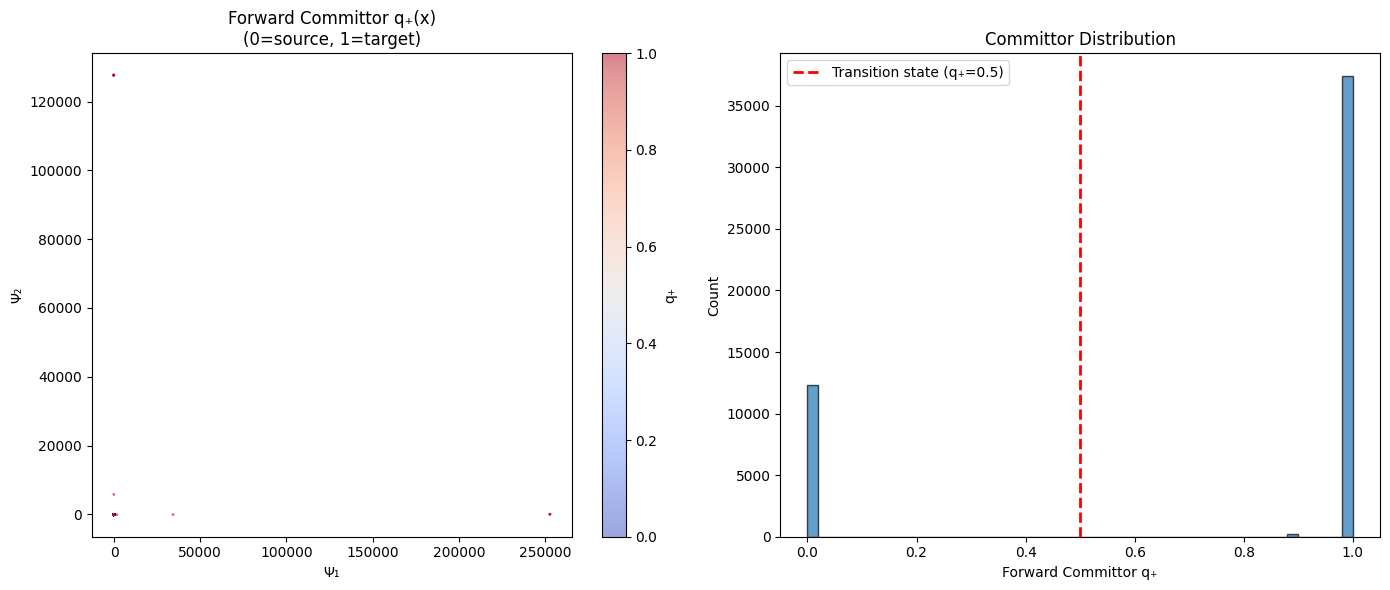

In [14]:
# ============================================================================
# VISUALIZE COMMITTOR FIELD
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Committor on diffusion coordinates
ax1 = axes[0]
scatter1 = ax1.scatter(dm_coords[:, 0], dm_coords[:, 1],
                       c=committor_per_sample, cmap='coolwarm', s=1, alpha=0.5)
ax1.set_xlabel('Ψ₁')
ax1.set_ylabel('Ψ₂')
ax1.set_title('Forward Committor q₊(x)\n(0=source, 1=target)')
plt.colorbar(scatter1, ax=ax1, label='q₊')

# Panel 2: Committor distribution
ax2 = axes[1]
ax2.hist(committor_per_sample, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Transition state (q₊=0.5)')
ax2.set_xlabel('Forward Committor q₊')
ax2.set_ylabel('Count')
ax2.set_title('Committor Distribution')
ax2.legend()

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'committor_field.png', dpi=150, bbox_inches='tight')
plt.show()


Bottleneck states (q₊ ≈ 0.5):
  Count: 0
  Samples in bottleneck: 0 (0.0%)


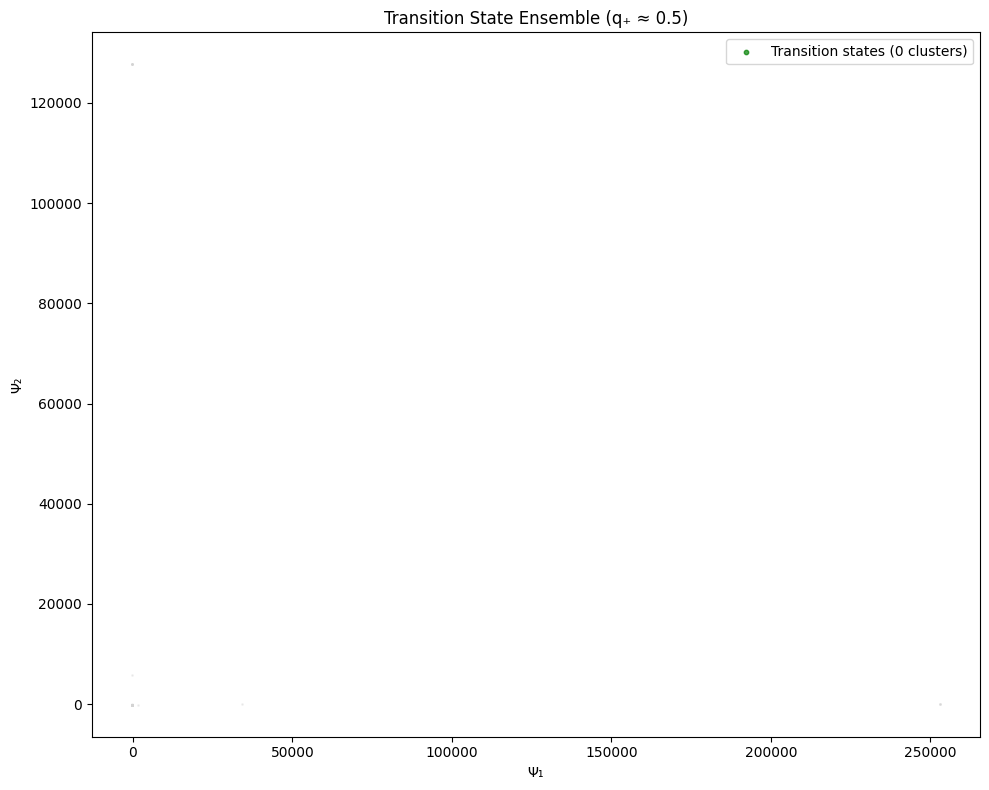

In [15]:
# ============================================================================
# IDENTIFY BOTTLENECK / TRANSITION STATES
# ============================================================================
bottleneck_states = tpt_analyzer.get_bottleneck_states(threshold=0.1)

print(f"\nBottleneck states (q₊ ≈ 0.5):")
print(f"  Count: {len(bottleneck_states)}")

# Samples in bottleneck states
bottleneck_mask = np.isin(state_labels, bottleneck_states)
print(f"  Samples in bottleneck: {bottleneck_mask.sum():,} ({bottleneck_mask.mean():.1%})")

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))

# Background
ax.scatter(dm_coords[:, 0], dm_coords[:, 1], c='lightgray', s=1, alpha=0.3)

# Bottleneck
ax.scatter(dm_coords[bottleneck_mask, 0], dm_coords[bottleneck_mask, 1],
           c='green', s=10, alpha=0.7, label=f'Transition states ({len(bottleneck_states)} clusters)')

ax.set_xlabel('Ψ₁')
ax.set_ylabel('Ψ₂')
ax.set_title('Transition State Ensemble (q₊ ≈ 0.5)')
ax.legend()

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'transition_states.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# ============================================================================
# PATHWAY DECOMPOSITION
# ============================================================================
with timed_section("Computing dominant pathways"):
    pathway_result = tpt_analyzer.find_pathways(
        fraction=CONFIG['tpt_pathway_fraction'],
        max_pathways=20
    )

    print(f"\nDominant Pathways:")
    print(f"  Total pathways: {len(pathway_result.paths)}")
    print(f"  Flux covered: {pathway_result.fraction_covered:.1%}")

    # Show top 5 pathways
    print(f"\n  Top 5 pathways:")
    for i, (path, flux) in enumerate(zip(pathway_result.paths[:5], pathway_result.fluxes[:5])):
        print(f"    {i+1}. {path[:5]}... → flux={flux:.4f}")

[START] Computing dominant pathways...

Dominant Pathways:
  Total pathways: 21
  Flux covered: 24.3%

  Top 5 pathways:
    1. [11, 22]... → flux=0.0005
    2. [79, 13]... → flux=0.0004
    3. [79, 22]... → flux=0.0004
    4. [65, 22]... → flux=0.0003
    5. [11, 57]... → flux=0.0002
[DONE] Computing dominant pathways: 0.1s (0.0 min)


/usr/local/lib/python3.12/dist-packages/deeptime/markov/tools/flux/pathways.py:294: RuntimeWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", RuntimeWarning)


## Statistical Validation: Shuffled Null Comparison

We compare our TPT results against a **shuffled null** baseline where temporal structure is destroyed by permuting game_ids. If our results are meaningful:
- Real data should have more bottleneck states
- Real flux coverage should be higher
- Transition rate should be different from shuffled

In [ ]:
# ============================================================================
# SHUFFLED NULL COMPARISON (Required per CLAUDE.md)
# ============================================================================
# Reference: docs/dynamical_systems_chaos/INDEX.md L:408-427 (Surrogate Data)

with timed_section("Shuffled Null Comparison"):
    print("="*60)
    print("SHUFFLED NULL COMPARISON (Required baseline per CLAUDE.md)")
    print("  'Shuffled surrogate should show fewer loops, p-value'")
    print("="*60)

    # Create shuffled game_ids (destroys temporal structure)
    n_shuffles = 10  # Number of shuffled surrogates
    shuffled_results = []

    for shuffle_i in range(n_shuffles):
        # Shuffle game_ids within the data (destroys trajectory structure)
        rng = np.random.default_rng(seed=shuffle_i)
        shuffled_game_ids = rng.permutation(game_ids_sub)

        # Re-build MSM with shuffled data
        msm_shuffled = TransitionMatrixAnalyzer(lag=CONFIG['tpt_lag'])
        try:
            msm_shuffled.fit(state_labels, shuffled_game_ids)

            # Run TPT on shuffled MSM
            tpt_shuffled = TPTAnalyzer(msm_shuffled.result_.transition_matrix)

            # Use same source/target state definitions
            tpt_result_shuffled = tpt_shuffled.compute_flux(
                source_states=list(source_states),
                target_states=list(target_states)
            )

            # Get bottleneck count
            bottleneck_shuffled = tpt_shuffled.get_bottleneck_states(threshold=0.1)

            shuffled_results.append({
                'total_flux': tpt_result_shuffled.total_flux,
                'rate': tpt_result_shuffled.rate,
                'n_bottlenecks': len(bottleneck_shuffled),
            })
        except Exception as e:
            print(f"  Shuffle {shuffle_i} failed: {e}")

    # Compare real vs shuffled
    real_flux = tpt_result.total_flux
    real_rate = tpt_result.rate
    real_bottlenecks = len(bottleneck_states)

    shuffled_flux = np.array([r['total_flux'] for r in shuffled_results])
    shuffled_rate = np.array([r['rate'] for r in shuffled_results])
    shuffled_bottlenecks = np.array([r['n_bottlenecks'] for r in shuffled_results])

    print(f"\nComparison (Real vs Shuffled):")
    print(f"  Total Flux:    Real={real_flux:.6f}, Shuffled={shuffled_flux.mean():.6f} ± {shuffled_flux.std():.6f}")
    print(f"  Rate:          Real={real_rate:.6f}, Shuffled={shuffled_rate.mean():.6f} ± {shuffled_rate.std():.6f}")
    print(f"  Bottlenecks:   Real={real_bottlenecks}, Shuffled={shuffled_bottlenecks.mean():.1f} ± {shuffled_bottlenecks.std():.1f}")

    # Compute p-values (one-sided)
    p_flux = (shuffled_flux >= real_flux).mean()
    p_rate = (shuffled_rate >= real_rate).mean()
    p_bottlenecks = (shuffled_bottlenecks >= real_bottlenecks).mean()

    print(f"\n  P-values (one-sided, proportion of shuffled >= real):")
    print(f"    Flux:        p={p_flux:.3f} {'< 0.05 ✓' if p_flux < 0.05 else '>= 0.05'}")
    print(f"    Rate:        p={p_rate:.3f} {'< 0.05 ✓' if p_rate < 0.05 else '>= 0.05'}")
    print(f"    Bottlenecks: p={p_bottlenecks:.3f} {'< 0.05 ✓' if p_bottlenecks < 0.05 else '>= 0.05'}")

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Flux comparison
    ax1 = axes[0]
    ax1.hist(shuffled_flux, bins=20, alpha=0.7, label='Shuffled', color='gray')
    ax1.axvline(real_flux, color='red', linestyle='--', linewidth=2, label=f'Real ({real_flux:.4f})')
    ax1.set_xlabel('Total Flux')
    ax1.set_ylabel('Count')
    ax1.set_title(f'Flux Distribution\np={p_flux:.3f}')
    ax1.legend()

    # Rate comparison
    ax2 = axes[1]
    ax2.hist(shuffled_rate, bins=20, alpha=0.7, label='Shuffled', color='gray')
    ax2.axvline(real_rate, color='red', linestyle='--', linewidth=2, label=f'Real ({real_rate:.4f})')
    ax2.set_xlabel('Transition Rate')
    ax2.set_ylabel('Count')
    ax2.set_title(f'Rate Distribution\np={p_rate:.3f}')
    ax2.legend()

    # Bottleneck comparison
    ax3 = axes[2]
    ax3.hist(shuffled_bottlenecks, bins=range(int(shuffled_bottlenecks.min()), int(shuffled_bottlenecks.max())+2),
             alpha=0.7, label='Shuffled', color='gray', align='left')
    ax3.axvline(real_bottlenecks, color='red', linestyle='--', linewidth=2, label=f'Real ({real_bottlenecks})')
    ax3.set_xlabel('Number of Bottleneck States')
    ax3.set_ylabel('Count')
    ax3.set_title(f'Bottleneck Distribution\np={p_bottlenecks:.3f}')
    ax3.legend()

    plt.tight_layout()
    plt.savefig(Path(CONFIG['output_dir']) / 'shuffled_null_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Save null comparison results
    null_comparison = {
        'real': {'flux': float(real_flux), 'rate': float(real_rate), 'bottlenecks': int(real_bottlenecks)},
        'shuffled_mean': {'flux': float(shuffled_flux.mean()), 'rate': float(shuffled_rate.mean()), 'bottlenecks': float(shuffled_bottlenecks.mean())},
        'shuffled_std': {'flux': float(shuffled_flux.std()), 'rate': float(shuffled_rate.std()), 'bottlenecks': float(shuffled_bottlenecks.std())},
        'p_values': {'flux': float(p_flux), 'rate': float(p_rate), 'bottlenecks': float(p_bottlenecks)},
    }
    with open(Path(CONFIG['output_dir']) / 'null_comparison.json', 'w') as f:
        json.dump(null_comparison, f, indent=2)
    print(f"\nSaved null comparison to null_comparison.json")

## 7. Output Artifacts

In [ ]:
# ============================================================================
# SAVE MANIFOLD COORDINATES (with TICA info)
# ============================================================================
with timed_section("Saving manifold coordinates"):
    output_path = Path(CONFIG['output_dir']) / 'manifold_coords.h5'

    with h5py.File(output_path, 'w') as f:
        # Diffusion coordinates for subsampled data
        f.create_dataset('diffusion_coords', data=dm_coords.astype(np.float32), compression='gzip')
        f.create_dataset('eigenvalues', data=dm_eigenvalues.astype(np.float32))
        f.create_dataset('subsample_indices', data=subsample_idx)

        # NEW: Save TICA features and parameters
        f.create_dataset('tica_coords', data=features_tica.astype(np.float32), compression='gzip')
        f.create_dataset('tica_eigenvalues', data=tica.result_.eigenvalues.astype(np.float32))
        f.create_dataset('tica_eigenvectors', data=tica.result_.eigenvectors.astype(np.float32), compression='gzip')
        f.create_dataset('tica_mean', data=tica.result_.mean.astype(np.float32))

        # Metadata
        f.attrs['n_samples'] = len(dm_coords)
        f.attrs['n_components'] = dm_coords.shape[1]
        f.attrs['alpha'] = CONFIG['dm_alpha']
        f.attrs['n_landmarks'] = CONFIG['dm_n_landmarks']
        f.attrs['tica_n_components'] = features_tica.shape[1]
        f.attrs['tica_lag'] = CONFIG['tica_lag']
        f.attrs['tica_selected_for_95pct_var'] = n_tica_selected

    print(f"Saved: {output_path}")

In [ ]:
# ============================================================================
# SAVE DYNAMICS POTENTIALS (COMMITTORS) + CLUSTERING INFO
# ============================================================================
with timed_section("Saving dynamics potentials"):
    output_path = Path(CONFIG['output_dir']) / 'dynamics_potentials.h5'

    with h5py.File(output_path, 'w') as f:
        # Committor per sample
        f.create_dataset('forward_committor', data=committor_per_sample.astype(np.float32), compression='gzip')

        # State-level quantities
        f.create_dataset('state_labels', data=state_labels, compression='gzip')
        f.create_dataset('state_committor', data=tpt_result.forward_committor.astype(np.float32))
        f.create_dataset('stationary_distribution', data=tpt_result.stationary_distribution.astype(np.float32))
        f.create_dataset('bottleneck_states', data=np.array(bottleneck_states))

        # Source/target
        f.create_dataset('source_states', data=np.array(source_states))
        f.create_dataset('target_states', data=np.array(target_states))

        # NEW: HDBSCAN cluster stability scores (if available)
        if hasattr(clusterer, 'cluster_persistence_'):
            f.create_dataset('cluster_persistence', data=clusterer.cluster_persistence_)

        # Metadata
        f.attrs['total_flux'] = tpt_result.total_flux
        f.attrs['rate'] = tpt_result.rate
        f.attrs['n_bottleneck_states'] = len(bottleneck_states)
        f.attrs['n_clusters'] = n_clusters
        f.attrs['n_noise_points'] = n_noise
        f.attrs['clustering_method'] = 'HDBSCAN'
        f.attrs['hdbscan_min_cluster_size'] = CONFIG['hdbscan_min_cluster_size']
        f.attrs['hdbscan_min_samples'] = CONFIG['hdbscan_min_samples']
        f.attrs['early_game_threshold'] = CONFIG['early_game_threshold']
        f.attrs['late_game_threshold'] = CONFIG['late_game_threshold']

    print(f"Saved: {output_path}")

In [19]:
# ============================================================================
# SAVE TPT RESULT
# ============================================================================
tpt_path = Path(CONFIG['output_dir']) / 'tpt_result.npz'
save_tpt_result(tpt_result, str(tpt_path))
print(f"Saved: {tpt_path}")

Saved: /content/drive/MyDrive/chaos/analysis/continuous_manifold/tpt_result.npz


In [ ]:
# ============================================================================
# SUMMARY (Updated with Literature Cross-Reference Fixes)
# ============================================================================
print("\n" + "="*70)
print("NOTEBOOK 5 v2 SUMMARY: CONTINUOUS MANIFOLD & DYNAMICS")
print("="*70)

print(f"\n1. DATA:")
print(f"   - Samples: {n_samples:,}")
print(f"   - Subsampled for analysis: {len(dm_coords):,}")

print(f"\n2. TICA PREPROCESSING (NEW - per CLAUDE.md):")
print(f"   - Input dimension: {features_sub.shape[1]} (raw SAE features)")
print(f"   - Output dimension: {features_tica.shape[1]} (TICA features)")
print(f"   - Lag: {CONFIG['tica_lag']}")
print(f"   - Components for 95% kinetic variance: {n_tica_selected}")

print(f"\n3. DIFFUSION MAP (on TICA features):")
print(f"   - Components: {dm_coords.shape[1]}")
print(f"   - α={CONFIG['dm_alpha']} (Laplace-Beltrami)")
print(f"   - Landmarks: {CONFIG['dm_n_landmarks']} (increased from 5000)")
print(f"   - Spectral gap: {dm_eigenvalues[0]/dm_eigenvalues[1]:.2f}" if len(dm_eigenvalues) > 1 else "   - Spectral gap: N/A")

print(f"\n4. CLUSTERING (HDBSCAN - per CLAUDE.md, NOT k-means):")
print(f"   - Clusters found: {n_clusters} (data-driven)")
print(f"   - Noise points: {n_noise:,} ({noise_fraction:.1%})")
print(f"   - Min cluster size: {CONFIG['hdbscan_min_cluster_size']}")

print(f"\n5. MSM VALIDATION (NEW - per CLAUDE.md):")
print(f"   - ITS convergence: tested at lags {CONFIG['its_lag_values']}")
print(f"   - Chapman-Kolmogorov: {'PASSED' if ck_result.passed else 'FAILED'}")

print(f"\n6. TPT ANALYSIS:")
print(f"   - States (non-noise): {msm_result.n_states}")
print(f"   - Source states: {len(source_states)} (threshold {CONFIG['early_game_threshold']})")
print(f"   - Target states: {len(target_states)} (threshold {CONFIG['late_game_threshold']})")
print(f"   - Bottleneck states: {len(bottleneck_states)}")
print(f"   - Dominant pathways: {len(pathway_result.paths)}")
print(f"   - Pathway flux coverage: {pathway_result.fraction_covered:.1%}")

print(f"\n7. STATISTICAL VALIDATION (NEW - per CLAUDE.md):")
print(f"   - Shuffled surrogates: {n_shuffles}")
print(f"   - P-value (flux): {p_flux:.3f}")
print(f"   - P-value (rate): {p_rate:.3f}")
print(f"   - P-value (bottlenecks): {p_bottlenecks:.3f}")

print(f"\n8. OUTPUT ARTIFACTS:")
print(f"   - {CONFIG['output_dir']}/manifold_coords.h5")
print(f"   - {CONFIG['output_dir']}/dynamics_potentials.h5")
print(f"   - {CONFIG['output_dir']}/tpt_result.npz")
print(f"   - {CONFIG['output_dir']}/msm_validation.json (NEW)")
print(f"   - {CONFIG['output_dir']}/null_comparison.json (NEW)")
print(f"   - {CONFIG['output_dir']}/its_convergence.png (NEW)")
print(f"   - {CONFIG['output_dir']}/shuffled_null_comparison.png (NEW)")

print(f"\n9. CHANGES FROM LITERATURE CROSS-REFERENCE:")
print(f"   ✓ Added TICA preprocessing before diffusion maps")
print(f"   ✓ Replaced k-means with HDBSCAN for clustering")
print(f"   ✓ Added ITS convergence test")
print(f"   ✓ Added Chapman-Kolmogorov test")
print(f"   ✓ Adjusted thresholds (0.2→0.15, 0.8→0.85)")
print(f"   ✓ Increased n_landmarks (5000→10000)")
print(f"   ✓ Added shuffled null comparison")

print(f"\n10. NEXT STEPS:")
print(f"   - Use q₊ to identify transition features: 'What SAE features are active when q₊ ≈ 0.5?'")
print(f"   - Analyze reactive flux highways for morphogenetic pathways")
print(f"   - Compare with random Leela baseline (separate notebook)")
print("="*70)